# Домашнее задание 5. Градиентный спуск.



In [2]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import itertools

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [3]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

### Задание 1.1 (5/8 балла): Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [4]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """

        return (np.sum((np.dot(X, w) - y) ** 2)) / len(y)


    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        return (2 * np.dot(X.T, (np.dot(X, w) - y))) / len(y)

In [5]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

### Задание 1.2 (5/8 балла): Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`,
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать
траекторию спуска (список из новых значений весов на каждом шаге)

In [6]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    w_cur = w_init

    return [w_cur := np.array(w_cur - lr * loss.calc_grad(X, y, w_cur)) for i in range(n_iterations)]

In [7]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [16]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

155.2625821435192
0.8670644395649493


In [8]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss, label: str):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title(label)
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

### Задание 1.3 (5/8 балла): При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`.

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

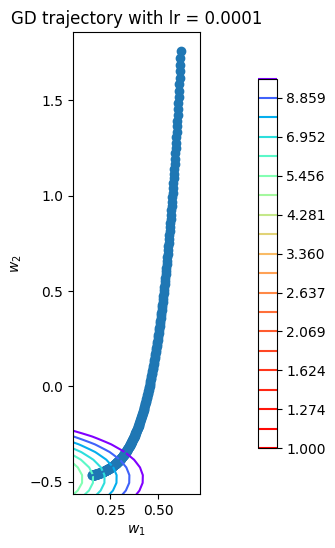

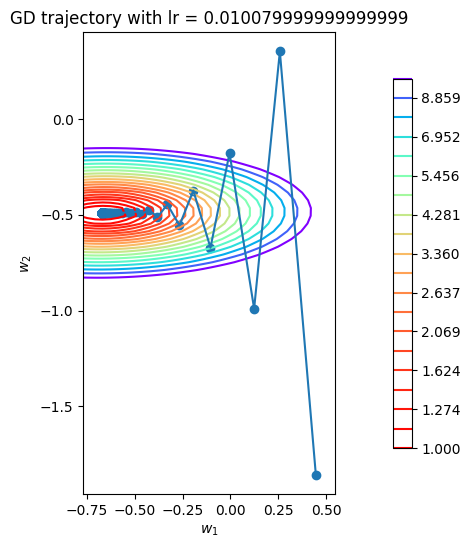

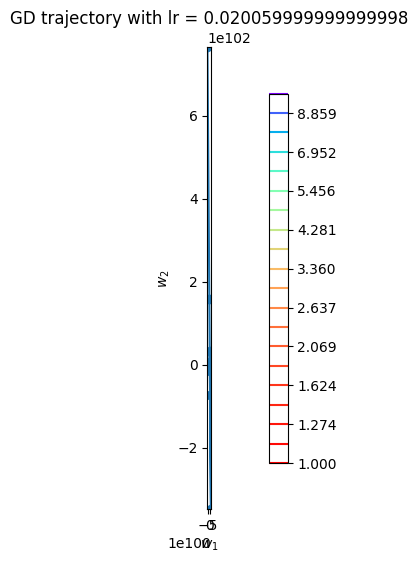

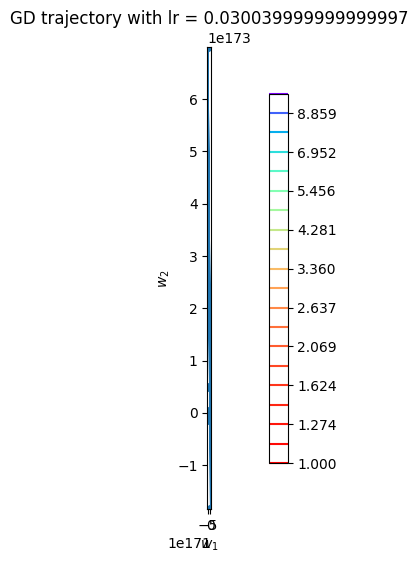

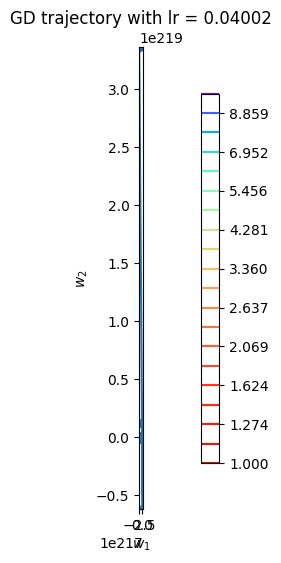

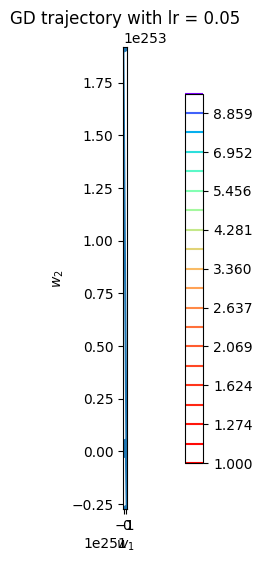

In [9]:
for lr in np.linspace(0.0001, 0.05, num=6):
    plot_gd(gradient_descent(w_init, X, y, loss, lr, 300), X, y, loss, f"GD trajectory with lr = {lr}")

При слишком маленьком значении `lr` (например, 0.0001) градиентный спуск слишком быстро "замедляется", не имея возможности набрать хороший "разбег" до центра.

В то время как слишком большие значения (предположительно от около 0.012) вызывают расхождение градиентного спуска. Его "качает" в сторону центра все сильнее и сильнее, из-за чего он продолжает улетать все дальше и дальше в бесконечность.

Наиболее оптимальное значение шага для представленных данных лежит в районе 0.01.

### Задание 1.4 (5/8 балла): Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]



In [10]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    w_cur = w_init
    sample = np.random.choice(X.shape[0], size=batch_size, replace=False)
    return [w_cur := np.array(w_cur - lr * loss.calc_grad(X[sample], y[sample], w_cur)) for i in range(n_iterations)]

### Задание 1.5 (5/8 балла): При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

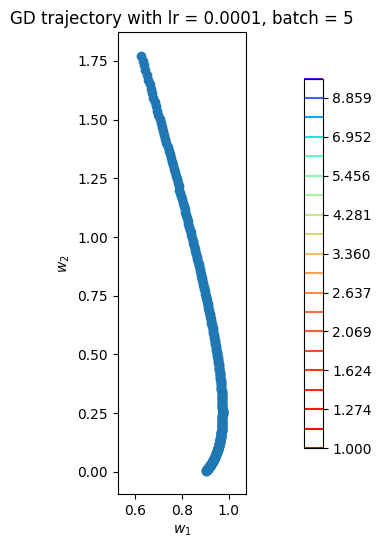

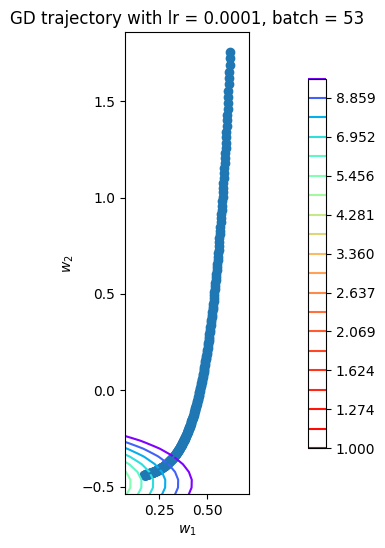

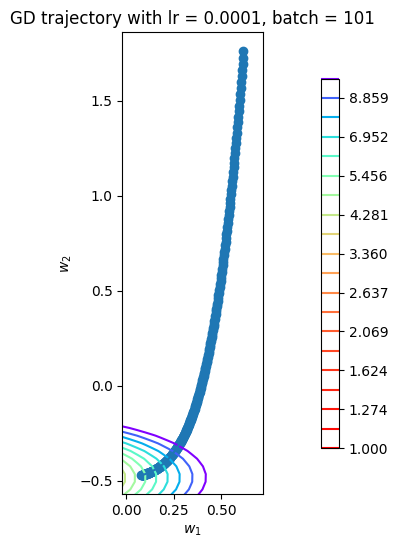

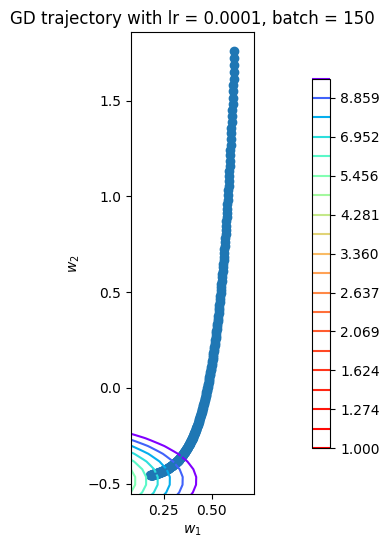

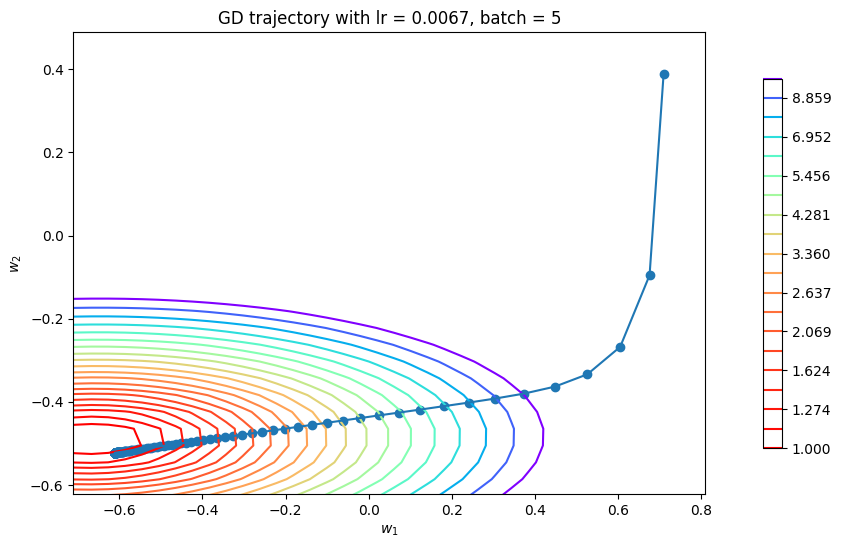

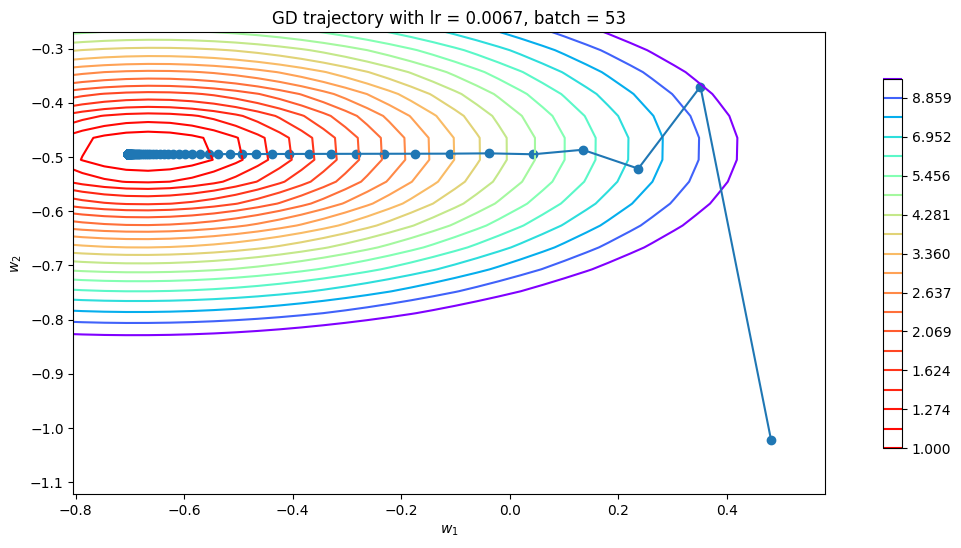

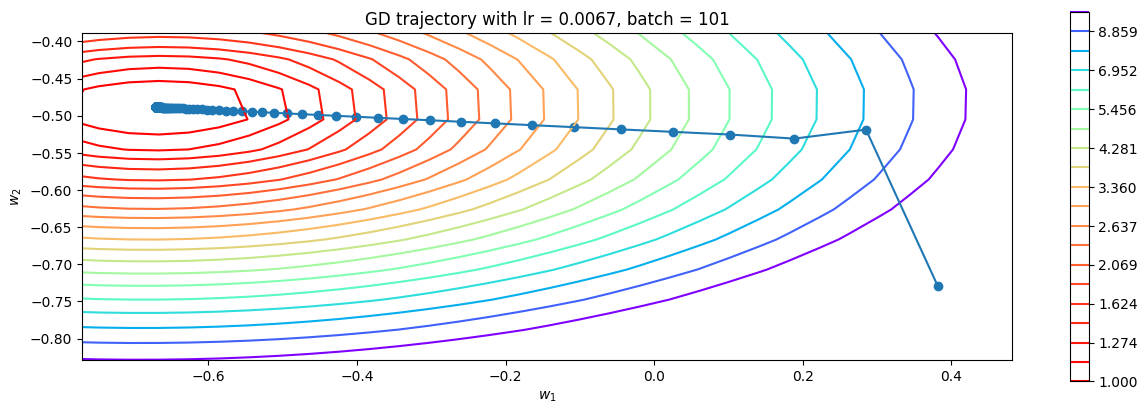

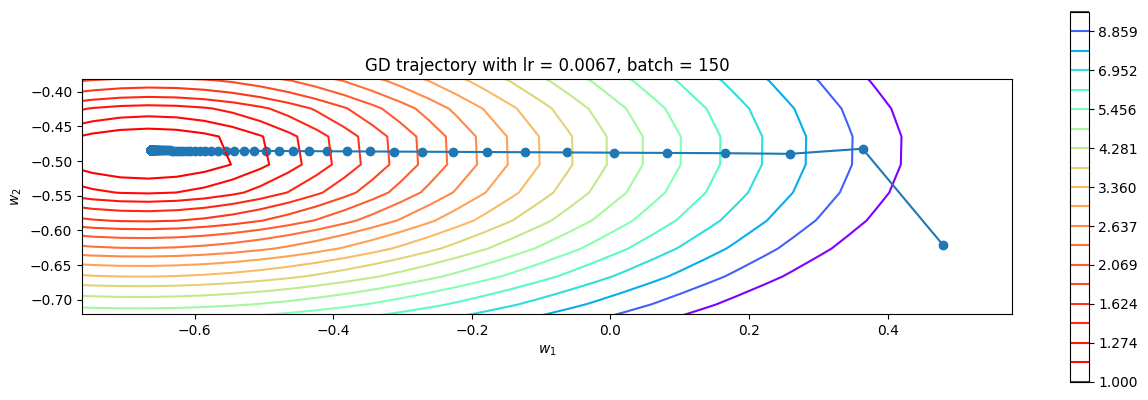

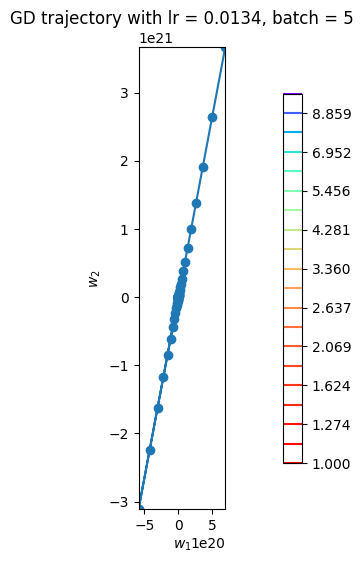

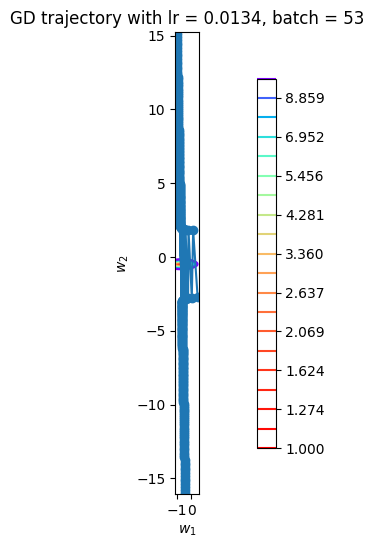

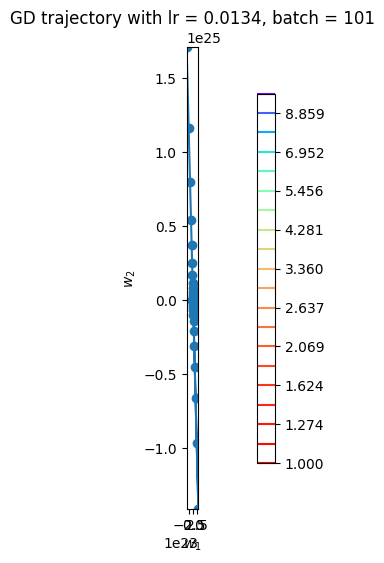

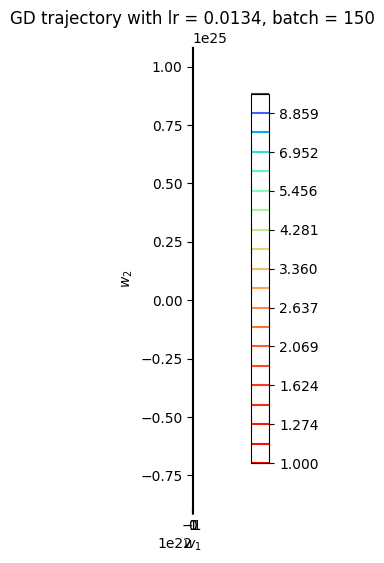

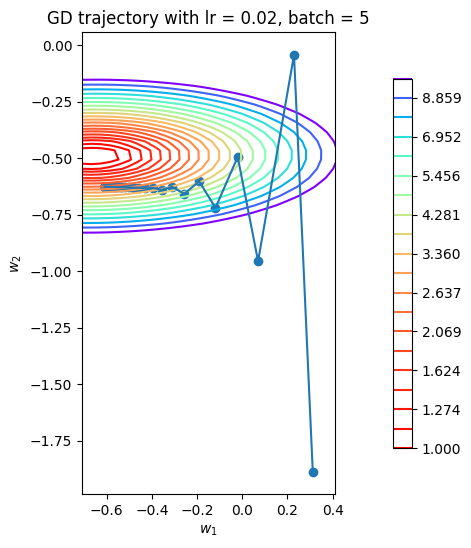

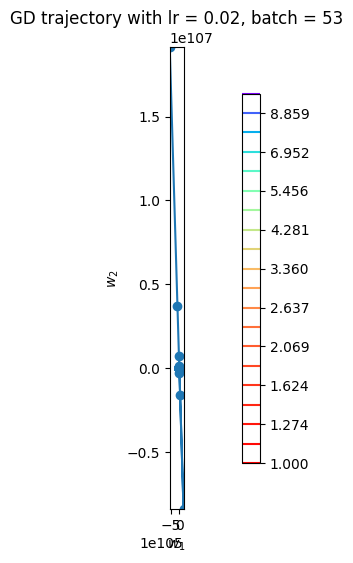

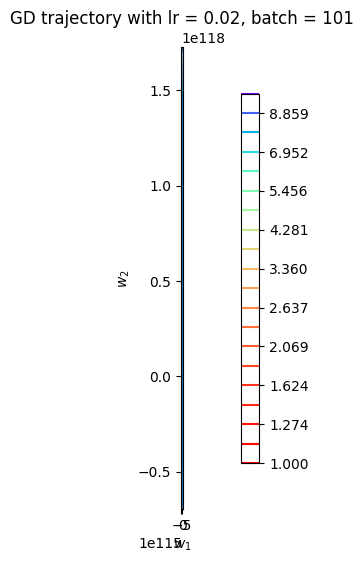

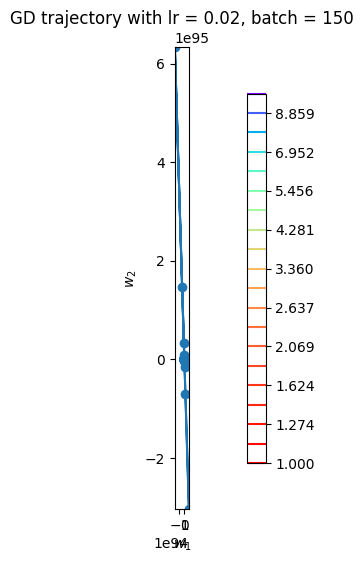

In [11]:
lr_var = np.linspace(0.0001, 0.02, num=4)
batch_var = np.linspace(5, 150, num=4, dtype=np.int32)

for lr_ind, batch_ind in itertools.product([0, 1, 2, 3], repeat=2):
    plot_gd(stochastic_gradient_descent(w_init, X, y, loss, lr_var[lr_ind], batch_var[batch_ind], 300), X, y, loss, f"GD trajectory with lr = {round(lr_var[lr_ind], 4)}, batch = {batch_var[batch_ind]}")

Немножко приблизил правую границу значения `lr` к левой, т.к. обычный град. спуск показал, что оптимальное значение находится где-то в районе 0.1.

Значение `lr`, как и в обычном град. спуске влияет на то, какой шаг будет у спуска. Чем больше, тем "сильнее" он шагает. При слишком маленьких значениях он никуда не доходит, при слишком больших - улетает в бесконечность.

Значение `batch`, в моем случае, влияет на результат по разному (возможно по причине того, что объекты каждый раз выбираются рандомно). В каких-то случаях низкий `batch` заставляет вести спуск более хаотично, в каких-то наоборот - стабилизирует ситуацию (например, на графике, где `lr` = 0.2, a batch = 5).

Стохастический градиентный спуск намного более хаотичен в сравнении с обычным из-за того, что в нем выбираются рандомные элементы выборки на каждом шагу.

### Задание 1.6 (5/8 балла): Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [12]:
def stochastic_gradient_descent_with_p(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    w_cur = w_init
    sample = np.random.choice(X.shape[0], size=batch_size, replace=False)

    global t
    t = 0

    def getNext():
        global t
        t += 1
        return np.array(w_cur - (lr * ((1 / (1 + t)) ** p)) * loss.calc_grad(X[sample], y[sample], w_cur))

    return [w_cur := getNext() for i in range(n_iterations)]

### Задание 1.7 (5/8 балла): При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`.

Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

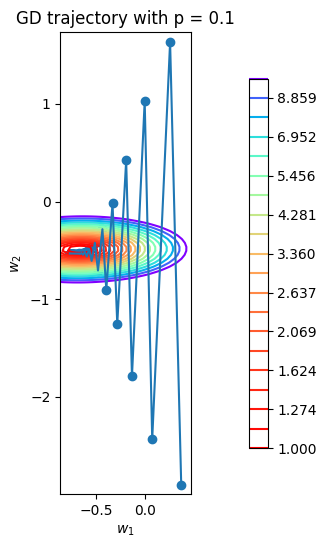

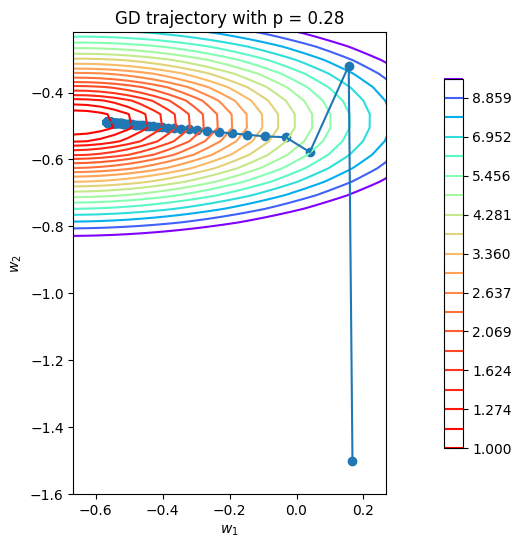

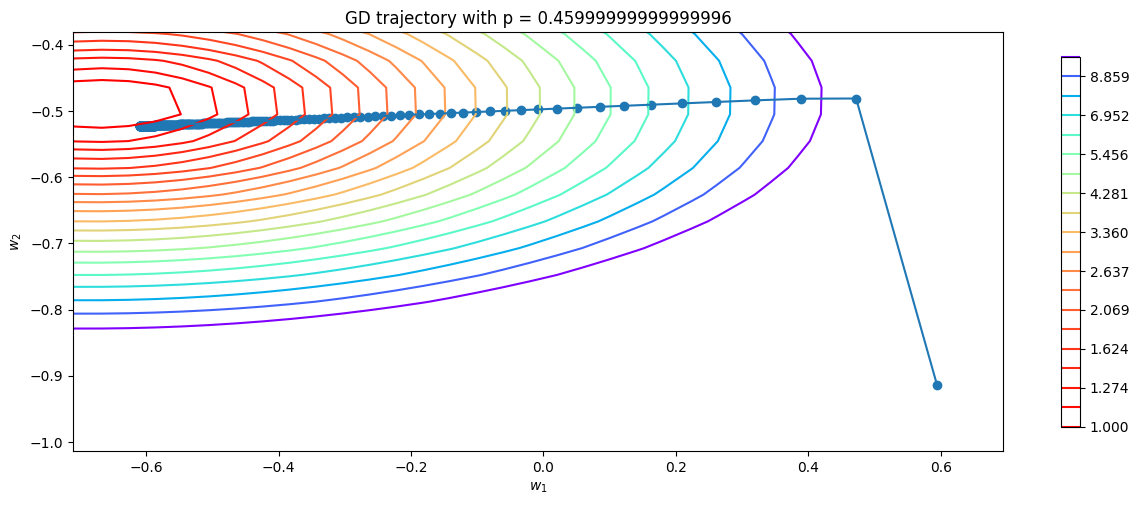

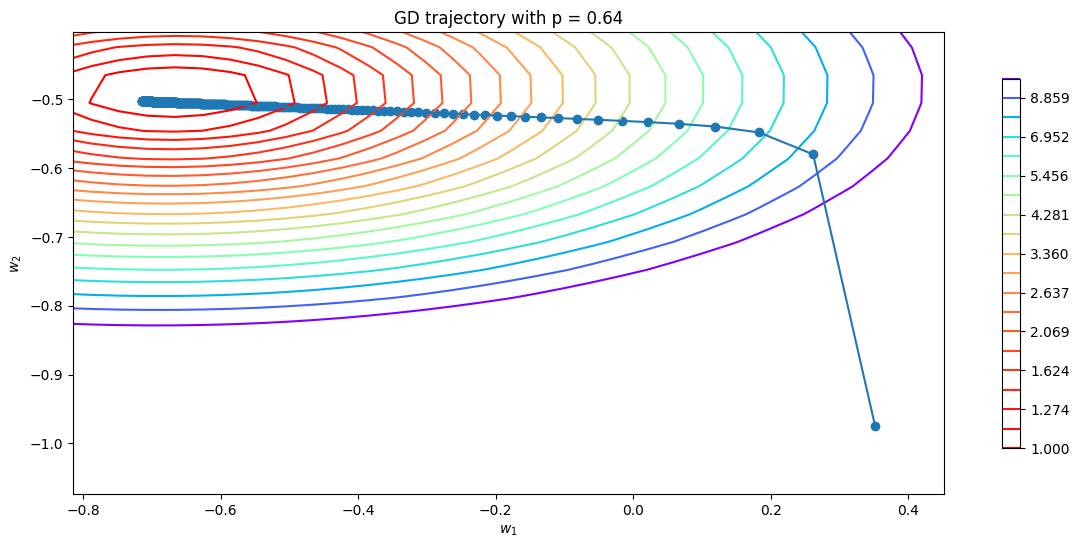

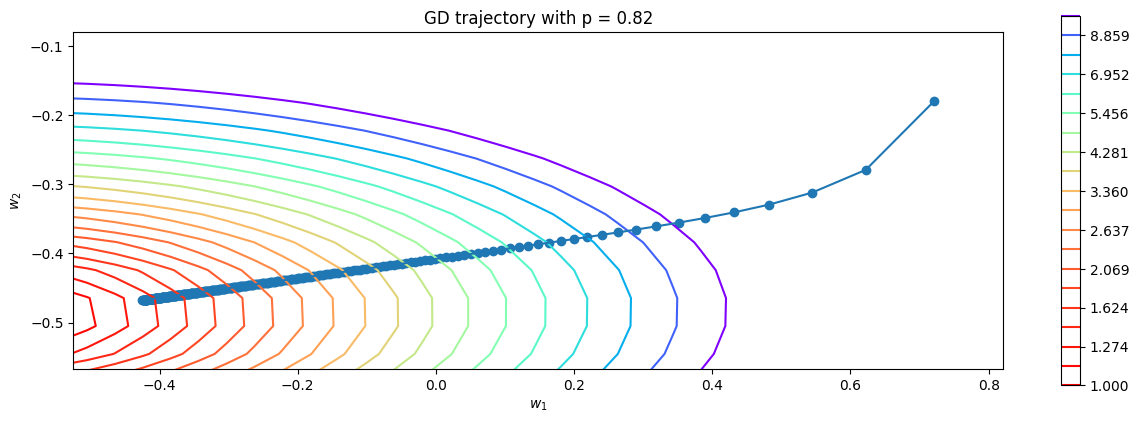

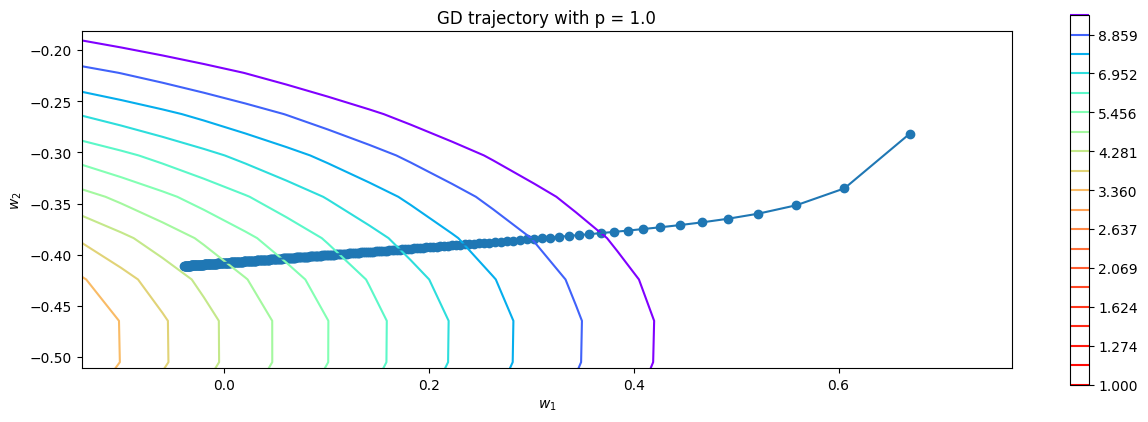

In [13]:
lr = 0.01
batch_size = 10

for p in np.linspace(0.1, 1, num=6):
    plot_gd(stochastic_gradient_descent_with_p(w_init, X, y, loss, lr, batch_size, p, 300), X, y, loss, f"GD trajectory with p = {p}")

Чем больше параметр `p`, тем быстрее "затухает" наш градиентный спуск, рискуя не дойти до нужного нам значения.

### Задание 1.8 (5/8 балла): Сравните сходимость обычного градиентного спуска и стохастичекой версии

Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

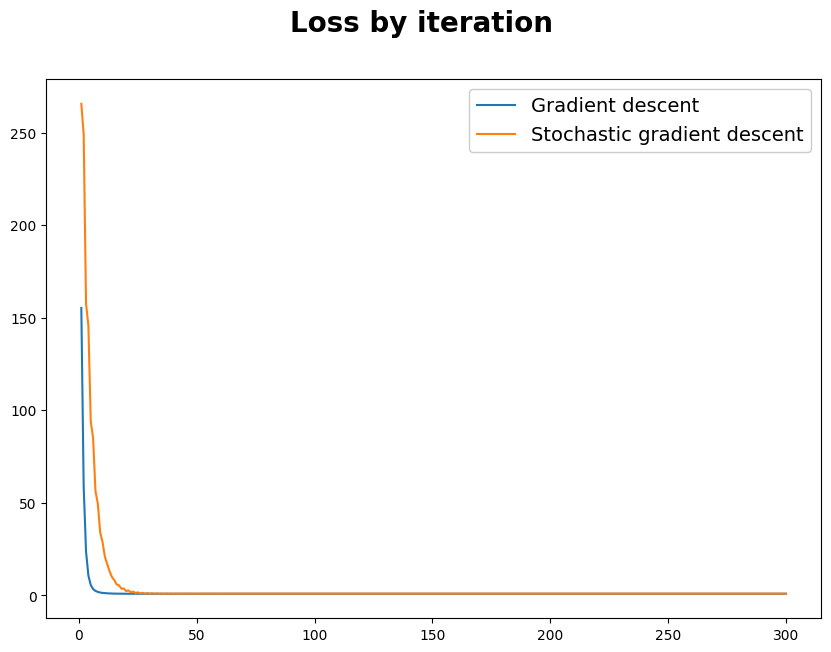

In [15]:
def helper(w, X, y):
    return loss.calc_loss(X, y, w)

lr = 0.01
batch = 10
iterations = 300

usual_weights = pd.Series(gradient_descent(w_init, X, y, loss, lr, iterations))
stochastic_weights = pd.Series(stochastic_gradient_descent(w_init, X, y, loss, lr, batch, iterations))

y_usual = usual_weights.apply(helper, X=X, y=y)
y_stochastic = stochastic_weights.apply(helper, X=X, y=y)

x = np.arange(1, iterations + 1)
fig, ax = plt.subplots(figsize=(10, 7))
fig.suptitle('Loss by iteration', fontsize=20, fontweight='bold')

plt.plot(x, y_usual, label='Gradient descent')
plt.plot(x, y_stochastic, label='Stochastic gradient descent')
plt.legend(fontsize=14, framealpha=1, facecolor='w')
plt.show()

На данном графике не то чтобы видно преимущество SGD, они поддерживают практически одинаковый паттерн, за исключением того, что SGD стартует немного ниже, чем GD. Однако, если взять в расчет, что во время стохастического спуска каждая итерация происходит в **30**(!) раз быстрее (т.к. batch = 10, а вся выборка = 300), то тогда уже можно говорить о том, что SGD сильно превосходит своего соперника.

Хотя стоит заметить, что потыкавшись здесь и построив несколько таких графиков, я нередко получал случаи, что SGD расходился или был немного хуже обычного GD. Стоит учитывать, что стохастический спуск зависит от случайных, выбранных им объектов выборки.

P.S. Я случайно перезапустил ячейку и теперь там немного другой график, не тот, о котором я изначально писал этот текст


## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету.

### Задание 2.1 (5/8 балла): Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [224]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        self.w = gradient_descent(np.zeros(X.shape[1]), X, y, self.loss, self.lr, 10000)[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return np.dot(X, self.w)

In [18]:
linear_regression = LinearRegression(MSELoss())

In [35]:
X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [36]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

### Задание 2.2 (5/8 балла): Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [37]:
X_raw.isna().sum().sum()

51

Значение выше не равно 0, следовательно, в датасете есть пропуски

In [38]:
X_raw = X_raw.apply(lambda column: column.fillna(column.mean()) if column.dtype.kind in 'biufc' else column.fillna('None'))

Заполняю числовые признаки медианой данного столбца, а нечисловые значением **None**

In [39]:
X_raw.isna().sum().sum()

0

Теперь пропусков нет!

In [41]:
X_raw

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,122.0,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
197,201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
198,202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
199,203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


In [45]:
X_raw.columns = X_raw.columns.astype(str)

num_cols = list(X_raw._get_numeric_data().columns)
cat_cols = list(set(X_raw.columns) - set(num_cols))

X_raw = pd.get_dummies(X_raw, columns = cat_cols, drop_first=True)

In [46]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_raw = scaler.fit_transform(X_raw)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)

### Задание 2.3 (5/8 балла): Обучите написанную вами линейную регрессию на обучающей выборке

In [100]:
lin_reg = LinearRegression(MSELoss(), 0.02)

lin_reg.fit(X_train, y_train)

### Задание 2.4 (5/8 балла): Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [101]:
from sklearn.metrics import mean_squared_error

y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("MSE on train:", mse_train)
print("MSE on test:", mse_test)

MSE on train: 1361172.4698069133
MSE on test: 8456339.870476542


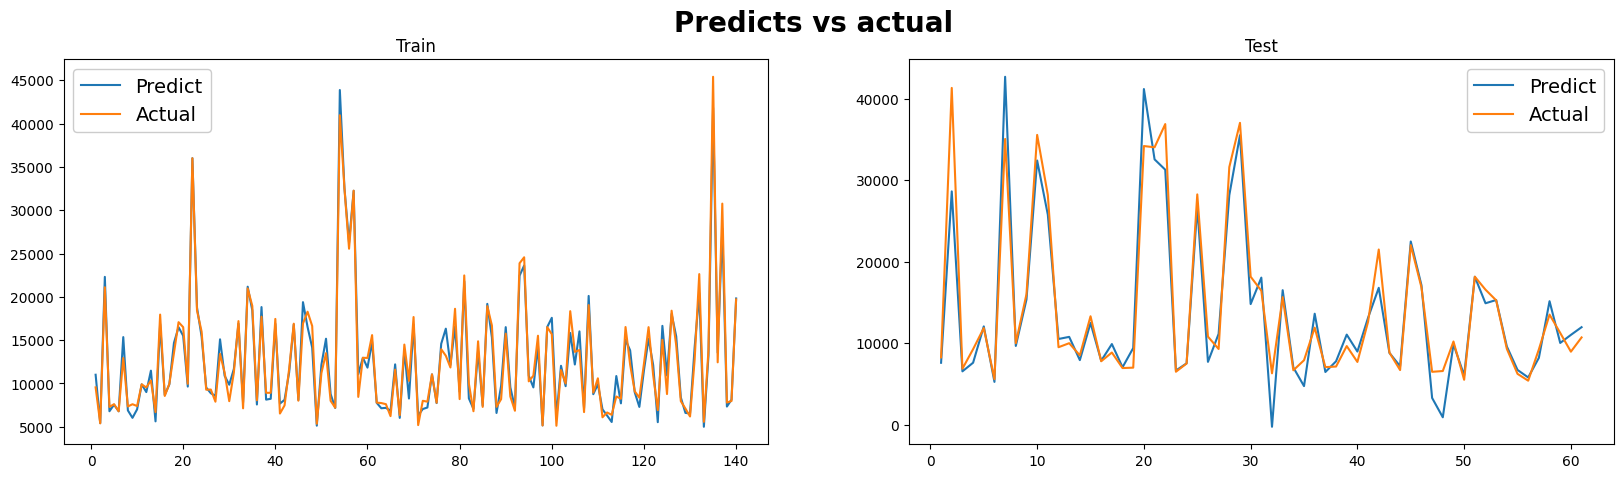

In [106]:
x_train_axis = np.arange(1, y_train_pred.shape[0] + 1)
x_test_axis = np.arange(1, y_test_pred.shape[0] + 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Predicts vs actual', fontsize=20, fontweight='bold')

ax[0].set_title('Train')
ax[0].plot(x_train_axis, y_train_pred, label='Predict')
ax[0].plot(x_train_axis, y_train, label='Actual')
ax[0].legend(fontsize=14, framealpha=1, facecolor='w')

ax[1].set_title('Test')
ax[1].plot(x_test_axis, y_test_pred, label='Predict')
ax[1].plot(x_test_axis, y_test, label='Actual')
ax[1].legend(fontsize=14, framealpha=1, facecolor='w')

plt.show()

### Задание 2.5 (5/8 балла): Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [109]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        return (np.sum((np.dot(X, w) - y) ** 2)) / len(y) + self.coef * np.sum(w[:-1] ** 2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        w_copy = w.copy()
        w_copy[-1] = 0

        return (2 * np.dot(X.T, (np.dot(X, w) - y))) / len(y) + 2 * self.coef * w_copy

### Задание 2.6 (5/8 балла): Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [147]:
lin_reg = LinearRegression(MSEL2Loss(0.014), 0.05)
lin_reg.fit(X_train, y_train)

y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("MSE on train:", mse_train)
print("MSE on test:", mse_test)

MSE on train: 1704789.099103992
MSE on test: 5648044.581053559


Добились улучшения качества модели примерно на 30% на тестовой выборке по сравнению с обычной MSELoss!

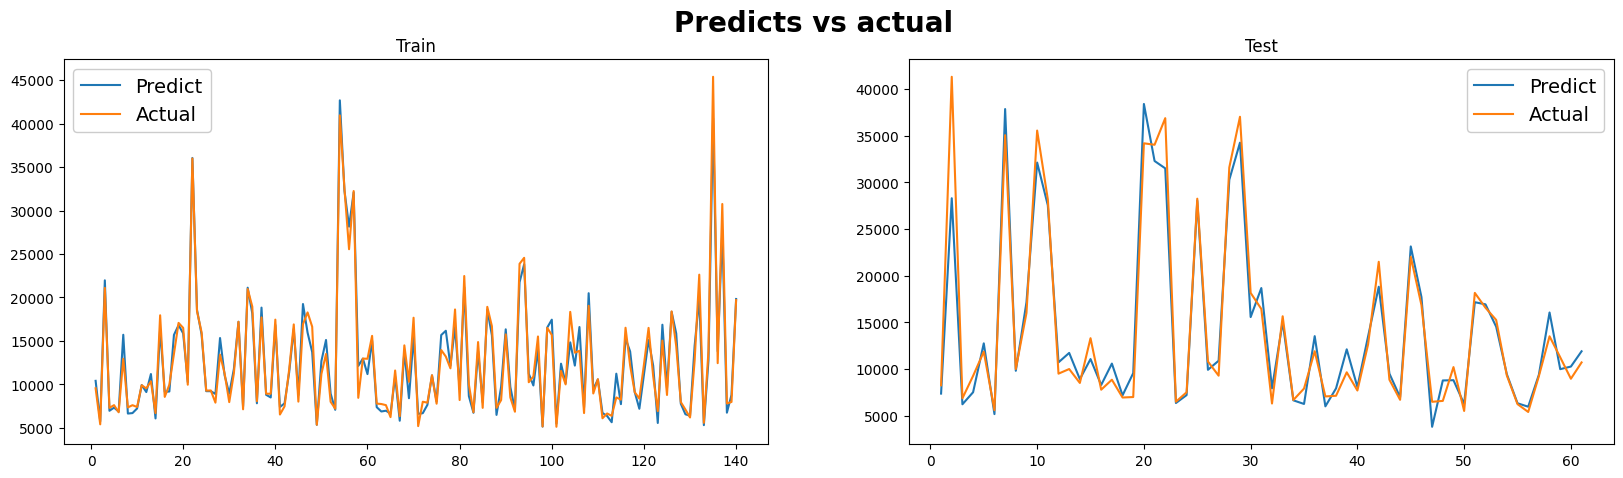

In [128]:
x_train_axis = np.arange(1, y_train_pred.shape[0] + 1)
x_test_axis = np.arange(1, y_test_pred.shape[0] + 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Predicts vs actual', fontsize=20, fontweight='bold')

ax[0].set_title('Train')
ax[0].plot(x_train_axis, y_train_pred, label='Predict')
ax[0].plot(x_train_axis, y_train, label='Actual')
ax[0].legend(fontsize=14, framealpha=1, facecolor='w')

ax[1].set_title('Test')
ax[1].plot(x_test_axis, y_test_pred, label='Predict')
ax[1].plot(x_test_axis, y_test, label='Actual')
ax[1].legend(fontsize=14, framealpha=1, facecolor='w')

plt.show()

### Задание 2.7 (5/8 балла): Реализуйте класс `HuberLoss`



В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [201]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """

        def fi(z: float):
            if -self.eps < z < self.eps:
                return (z ** 2) / 2

            return self.eps * (np.abs(z) - self.eps / 2)

        indexes = np.arange(0, y.shape[0])
        Q = indexes.apply(lambda index: fi(np.dot(X[index], w) - y[index]))

        return (np.sum(Q)) / y.shape[0]

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        def fi(z: float):
            if -self.eps < z < self.eps:
                return z

            return self.eps * np.sign(z)

        indexes = pd.Series(range(0, y.shape[0]))
        Q = indexes.apply(lambda index: X[index] * fi(np.dot(X[index], w) - y[index]))

        return (np.sum(Q)) / y.shape[0]

### Задание 2.8 (5/8 балла): Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [227]:
lin_reg = LinearRegression(HuberLoss(500), 0.05)
lin_reg.fit(X_train, y_train)

y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("MSE on train:", mse_train)
print("MSE on test:", mse_test)

MSE on train: 1955469.4678742145
MSE on test: 6416036.991772839


Лично я не смог подобрать данные, которые были бы лучше, чем MSEL2Loss, но я уверен, что это можно сделать.

### Задание 3 (0.08/8 балла)
Вставьте ваш любимый мем 2021 в ячейку ниже:

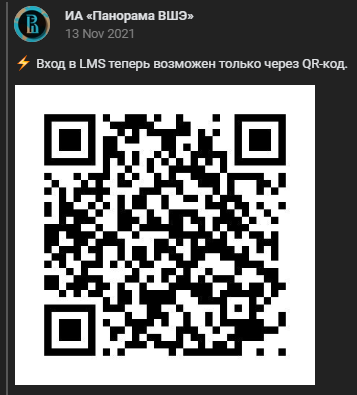